# Prywatność różnicowa i uczenie federcyjne MINST



## Przygotowanie środowiska


In [1]:
!pip install --quiet --upgrade tensorflow-federated-nightly
!pip install --quiet --upgrade nest-asyncio
!pip install --quiet --upgrade tb-nightly  

import nest_asyncio
import collections
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff
import tensorflow_privacy as tfp
from matplotlib import pyplot as plt

     |████████████████████████████████| 821 kB 4.3 MB/s 
     |████████████████████████████████| 543.5 MB 12 kB/s 
     |████████████████████████████████| 121 kB 50.3 MB/s 
     |████████████████████████████████| 251 kB 70.6 MB/s 
     |████████████████████████████████| 126 kB 77.0 MB/s 
     |████████████████████████████████| 65.1 MB 1.5 MB/s 
     |████████████████████████████████| 45 kB 2.4 MB/s 
     |████████████████████████████████| 238 kB 50.9 MB/s 
     |████████████████████████████████| 4.2 MB 41.9 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 887 kB 52.5 MB/s 
     |████████████████████████████████| 6.0 MB 27.5 MB/s 
     |████████████████████████████████| 1.7 MB 59.7 MB/s 
     |████████████████████████████████| 439 kB 74.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 r

In [2]:
nest_asyncio.apply()

@tff.federated_computation
def start():
  return 'Federated learning + differential privacy'

start()

b'Federated learning + differential privacy'

## Przygotowanie danych

In [3]:
train, test = tff.simulation.datasets.emnist.load_data(
      only_digits=True)

In [4]:
print("Typ struktury") 
train.element_type_structure

Typ struktury


OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int32, name=None)),
             ('pixels',
              TensorSpec(shape=(28, 28), dtype=tf.float32, name=None))])

In [5]:
print("Liczba użytkowników w zbiorze treningowym") 
len(train.client_ids)

Liczba użytkowników w zbiorze treningowym


3383

In [6]:
print("Liczba użytkowników w zbiorze treningowym") 
len(test.client_ids)

Liczba użytkowników w zbiorze treningowym


3383

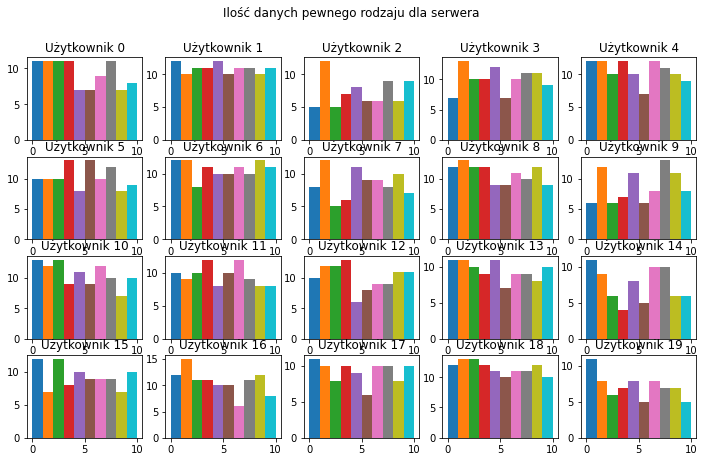

In [7]:
figure_1 = plt.figure(figsize=(12, 7))
figure_1.suptitle('Ilość danych pewnego rodzaju dla serwera')
for i in range(20):
  first_clients_data = train.create_tf_dataset_for_client(train.client_ids[i])
  plot = collections.defaultdict(list)
  for example in first_clients_data:
    label = example['label'].numpy()
    plot[label].append(label)
  plt.subplot(4, 5, i+1)
  plt.title('Użytkownik {}'.format(i))
  for number in range(10):
    plt.hist(
        plot[number],
        density=False,
        bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])


In [8]:
all_statistics = [[],[],[],[],[],[],[],[],[],[]]
clients_sum = []
for i in range(len(test.client_ids)):
  dataset = train.create_tf_dataset_for_client(train.client_ids[i])
  clients_sum.append(0)
  if (i % 750 == 0):
    print("Użytkownik: " + str(i))
  for j in range(10):
    all_statistics[j].append(0)
  for example in dataset:
    label = example['label'].numpy()
    all_statistics[label][i] += 1
    clients_sum[i] += 1


Użytkownik: 0
Użytkownik: 750
Użytkownik: 1500
Użytkownik: 2250
Użytkownik: 3000


In [9]:
from numpy import std,mean
print("Średnia ilość próbek " + str(mean(clients_sum)))
print("Średnie ochylenie standardowe ilości próbek  " + str(std(clients_sum)))

Średnia ilość próbek 101.0561631687851
Średnie ochylenie standardowe ilości próbek  14.725162999488088


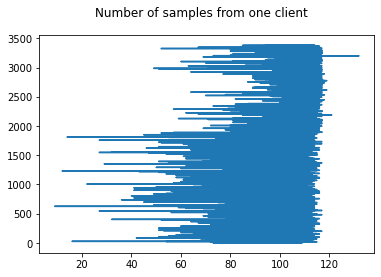

In [10]:
figure_2 = plt.figure()
figure_2.suptitle('Number of samples from one client')

plt.plot(clients_sum, list(range(0, len(train.client_ids))))
plt.show()

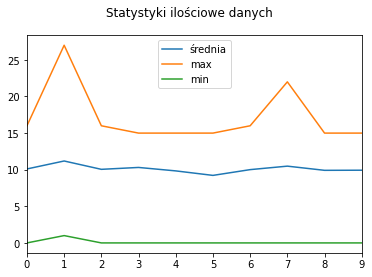

In [11]:
from numpy.core.fromnumeric import mean

plot_statistics_list = [[],[],[]]
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
for i in range(10):
  plot_statistics_list[0].append(mean(all_statistics[i]))
  plot_statistics_list[1].append(max(all_statistics[i]))
  plot_statistics_list[2].append(min(all_statistics[i]))

figure_3 = plt.figure()
figure_3.suptitle('Statystyki ilościowe danych')

plt.xlim(0, 9)
plt.plot(bins, plot_statistics_list[0], label = "średnia")
plt.plot(bins, plot_statistics_list[1], label = "max")
plt.plot(bins, plot_statistics_list[2], label = "min")
plt.legend()
plt.show()

In [12]:
def get_emnist_dataset():
  emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data(
      only_digits=True)

  def element_change(element):
    return collections.OrderedDict(
        x=tf.expand_dims(element['pixels'], -1), y=element['label'])

  def train_preprocess(dataset):
    return (dataset.map(element_change)
                   .shuffle(buffer_size=418)
                   .repeat(1)
                   .batch(32, drop_remainder=False))

  def test_preprocess(dataset):
    return dataset.map(element_change).batch(128, drop_remainder=False)

  emnist_train = emnist_train.preprocess(train_preprocess)
  emnist_test = test_preprocess(
      emnist_test.create_tf_dataset_from_all_clients())
  return emnist_train, emnist_test

emnist_train, emnist_test = get_emnist_dataset()


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [13]:
def my_model_fn():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Reshape(input_shape=(28, 28, 1), target_shape=(28 * 28,)),
      tf.keras.layers.Dense(200, activation=tf.nn.relu),
      tf.keras.layers.Dense(200, activation=tf.nn.relu),
      tf.keras.layers.Dense(10)])
  return tff.learning.from_keras_model(
      keras_model=model,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      input_spec=emnist_test.element_spec,
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [14]:
tff.backends.native.set_local_python_execution_context(clients_per_thread=10)

total_clients = len(emnist_train.client_ids)

def train(rounds, noise_multiplier, clients_per_round, data_frame):
  aggregation_factory = tff.learning.model_update_aggregator.dp_aggregator(
      noise_multiplier, clients_per_round)

  sampling_prob = clients_per_round / total_clients

  learning_process = tff.learning.algorithms.build_unweighted_fed_avg(
        my_model_fn,
        client_optimizer_fn=lambda: tf.keras.optimizers.SGD(0.01),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(1.0, momentum=0.9),
        model_aggregator=aggregation_factory)

  eval_process = tff.learning.build_federated_evaluation(my_model_fn)

  state = learning_process.initialize()
  for round in range(rounds):
    if round % 2 == 0:
      model_weights = learning_process.get_model_weights(state)
      metrics = eval_process(model_weights, [emnist_test])['eval']
      print(f'Runda {round:3d}: {metrics}')
      data_frame = data_frame.append({'Runda': round,
                                      'NoiseMultiplier': noise_multiplier,
                                      **metrics}, ignore_index=True)
    x = np.random.uniform(size=total_clients)
    sampled_clients = [
        emnist_train.client_ids[i] for i in range(total_clients)
        if x[i] < sampling_prob]
    sampled_train_data = [
        emnist_train.create_tf_dataset_for_client(client)
        for client in sampled_clients]

    result = learning_process.next(state, sampled_train_data)
    state = result.state
    metrics = result.metrics

  model_weights = learning_process.get_model_weights(state)
  metrics = eval_process(model_weights, [emnist_test])['eval']
  print(f'Runda {rounds:3d}: {metrics}')
  data_frame = data_frame.append({'Runda': rounds,
                                  'NoiseMultiplier': noise_multiplier,
                                  **metrics}, ignore_index=True)

  return data_frame


Proces testowania


In [15]:
def client10(noise_multiplier):
  rounds = 2
  clients_per_round = 10
  data_noise_10_clients_basic_model = pd.DataFrame()

  print("Mnożnik szumu " + str(noise_multiplier))

  data_noise_10_clients_basic_model = train(rounds, noise_multiplier, clients_per_round, data_noise_10_clients_basic_model)
  print()

  return data_noise_10_clients_basic_model


In [16]:
buff = client10(0.0)

Mnożnik szumu 0.0
Runda   0: OrderedDict([('sparse_categorical_accuracy', 0.100582875), ('loss', 2.6813045), ('num_examples', 40832), ('num_batches', 319)])
Runda   2: OrderedDict([('sparse_categorical_accuracy', 0.08451705), ('loss', 2.3999476), ('num_examples', 40832), ('num_batches', 319)])



In [17]:
buff = client10(0.25)

Mnożnik szumu 0.25
Runda   0: OrderedDict([('sparse_categorical_accuracy', 0.09024785), ('loss', 2.681518), ('num_examples', 40832), ('num_batches', 319)])
Runda   2: OrderedDict([('sparse_categorical_accuracy', 0.102125786), ('loss', 2.2954292), ('num_examples', 40832), ('num_batches', 319)])



In [18]:
buff = client10(0.5)

Mnożnik szumu 0.5
Runda   0: OrderedDict([('sparse_categorical_accuracy', 0.09913793), ('loss', 2.731355), ('num_examples', 40832), ('num_batches', 319)])
Runda   2: OrderedDict([('sparse_categorical_accuracy', 0.09039479), ('loss', 2.3207817), ('num_examples', 40832), ('num_batches', 319)])



In [19]:
buff = client10(0.75)

Mnożnik szumu 0.75
Runda   0: OrderedDict([('sparse_categorical_accuracy', 0.108395375), ('loss', 2.444168), ('num_examples', 40832), ('num_batches', 319)])
Runda   2: OrderedDict([('sparse_categorical_accuracy', 0.09580721), ('loss', 2.424678), ('num_examples', 40832), ('num_batches', 319)])



In [20]:
def client30(noise_multiplier):
  data_noise_30_clients_basic_model = pd.DataFrame()
  rounds = 2
  clients_per_round = 30

  print("Mnożnik szumu " + str(noise_multiplier))

  data_noise_30_clients_basic_model = train(rounds, noise_multiplier, clients_per_round, data_noise_30_clients_basic_model)
  print()

  return data_noise_30_clients_basic_model

In [21]:
buff = client30(0.0)

Mnożnik szumu 0.0
Runda   0: OrderedDict([('sparse_categorical_accuracy', 0.104280956), ('loss', 2.7640808), ('num_examples', 40832), ('num_batches', 319)])
Runda   2: OrderedDict([('sparse_categorical_accuracy', 0.15610306), ('loss', 2.3771768), ('num_examples', 40832), ('num_batches', 319)])



In [22]:
buff = client30(0.25)

Mnożnik szumu 0.25
Runda   0: OrderedDict([('sparse_categorical_accuracy', 0.0913989), ('loss', 2.557013), ('num_examples', 40832), ('num_batches', 319)])
Runda   2: OrderedDict([('sparse_categorical_accuracy', 0.18416928), ('loss', 2.3005764), ('num_examples', 40832), ('num_batches', 319)])



In [23]:
buff = client30(0.5)

Mnożnik szumu 0.5
Runda   0: OrderedDict([('sparse_categorical_accuracy', 0.1052116), ('loss', 2.3903818), ('num_examples', 40832), ('num_batches', 319)])
Runda   2: OrderedDict([('sparse_categorical_accuracy', 0.09923589), ('loss', 2.2993577), ('num_examples', 40832), ('num_batches', 319)])



In [24]:
buff = client30(0.75)

Mnożnik szumu 0.75
Runda   0: OrderedDict([('sparse_categorical_accuracy', 0.09379898), ('loss', 2.6691437), ('num_examples', 40832), ('num_batches', 319)])
Runda   2: OrderedDict([('sparse_categorical_accuracy', 0.10817496), ('loss', 2.3201368), ('num_examples', 40832), ('num_batches', 319)])



In [25]:
buff = client30(1.0)

Mnożnik szumu 1.0
Runda   0: OrderedDict([('sparse_categorical_accuracy', 0.088949844), ('loss', 2.6983192), ('num_examples', 40832), ('num_batches', 319)])
Runda   2: OrderedDict([('sparse_categorical_accuracy', 0.0986971), ('loss', 2.3540847), ('num_examples', 40832), ('num_batches', 319)])



In [26]:
def client50(noise_multiplier):
  data_noise_50_clients_basic_model = pd.DataFrame()
  rounds = 2
  clients_per_round = 50

  print("Mnożnik szumu " + str(noise_multiplier))
  data_noise_50_clients_basic_model = train(rounds, noise_multiplier, clients_per_round, data_noise_50_clients_basic_model)
  print()

  return data_noise_50_clients_basic_model


In [27]:
buff = client50(0.0)

Mnożnik szumu 0.0
Runda   0: OrderedDict([('sparse_categorical_accuracy', 0.053365007), ('loss', 2.478124), ('num_examples', 40832), ('num_batches', 319)])
Runda   2: OrderedDict([('sparse_categorical_accuracy', 0.098525666), ('loss', 2.33888), ('num_examples', 40832), ('num_batches', 319)])



In [28]:
buff = client50(0.25)

Mnożnik szumu 0.25
Runda   0: OrderedDict([('sparse_categorical_accuracy', 0.09742359), ('loss', 2.5057008), ('num_examples', 40832), ('num_batches', 319)])
Runda   2: OrderedDict([('sparse_categorical_accuracy', 0.11659972), ('loss', 2.3317466), ('num_examples', 40832), ('num_batches', 319)])



In [29]:
buff = client50(0.5)

Mnożnik szumu 0.5
Runda   0: OrderedDict([('sparse_categorical_accuracy', 0.100705326), ('loss', 2.5870993), ('num_examples', 40832), ('num_batches', 319)])
Runda   2: OrderedDict([('sparse_categorical_accuracy', 0.0994808), ('loss', 2.3524091), ('num_examples', 40832), ('num_batches', 319)])



In [30]:
buff = client50(0.75)

Mnożnik szumu 0.75
Runda   0: OrderedDict([('sparse_categorical_accuracy', 0.09828076), ('loss', 2.3929768), ('num_examples', 40832), ('num_batches', 319)])
Runda   2: OrderedDict([('sparse_categorical_accuracy', 0.14527822), ('loss', 2.303288), ('num_examples', 40832), ('num_batches', 319)])



In [31]:
buff = client50(1.0)

Mnożnik szumu 1.0
Runda   0: OrderedDict([('sparse_categorical_accuracy', 0.09575823), ('loss', 2.4736624), ('num_examples', 40832), ('num_batches', 319)])
Runda   2: OrderedDict([('sparse_categorical_accuracy', 0.082876176), ('loss', 2.311419), ('num_examples', 40832), ('num_batches', 319)])



In [32]:
def client70(noise_multiplier):
  data_noise_70_clients_basic_model = pd.DataFrame()
  rounds = 2
  clients_per_round = 70

  print("Mnożnik szumu " + str(noise_multiplier))
  data_noise_70_clients_basic_model = train(rounds, noise_multiplier, clients_per_round, data_noise_70_clients_basic_model)
  print()

  return data_noise_70_clients_basic_model

In [33]:
buff = client70(0.0)

Mnożnik szumu 0.0
Runda   0: OrderedDict([('sparse_categorical_accuracy', 0.11221591), ('loss', 2.452735), ('num_examples', 40832), ('num_batches', 319)])
Runda   2: OrderedDict([('sparse_categorical_accuracy', 0.10303193), ('loss', 2.3497317), ('num_examples', 40832), ('num_batches', 319)])



In [34]:
buff = client70(0.25)

Mnożnik szumu 0.25
Runda   0: OrderedDict([('sparse_categorical_accuracy', 0.09796238), ('loss', 2.4345279), ('num_examples', 40832), ('num_batches', 319)])
Runda   2: OrderedDict([('sparse_categorical_accuracy', 0.106264696), ('loss', 2.308259), ('num_examples', 40832), ('num_batches', 319)])



In [35]:
buff = client70(0.5)

Mnożnik szumu 0.5
Runda   0: OrderedDict([('sparse_categorical_accuracy', 0.09223159), ('loss', 2.5554998), ('num_examples', 40832), ('num_batches', 319)])
Runda   2: OrderedDict([('sparse_categorical_accuracy', 0.17875686), ('loss', 2.284403), ('num_examples', 40832), ('num_batches', 319)])



In [36]:
buff = client70(0.75)

Mnożnik szumu 0.75
Runda   0: OrderedDict([('sparse_categorical_accuracy', 0.10036246), ('loss', 2.6661122), ('num_examples', 40832), ('num_batches', 319)])
Runda   2: OrderedDict([('sparse_categorical_accuracy', 0.10655858), ('loss', 2.3164082), ('num_examples', 40832), ('num_batches', 319)])



In [37]:
buff = client70(1.2)

Mnożnik szumu 1.2
Runda   0: OrderedDict([('sparse_categorical_accuracy', 0.09357856), ('loss', 2.526263), ('num_examples', 40832), ('num_batches', 319)])
Runda   2: OrderedDict([('sparse_categorical_accuracy', 0.09590517), ('loss', 2.3461683), ('num_examples', 40832), ('num_batches', 319)])



In [38]:
buff = client70(1.4)

Mnożnik szumu 1.4
Runda   0: OrderedDict([('sparse_categorical_accuracy', 0.10173394), ('loss', 2.5762272), ('num_examples', 40832), ('num_batches', 319)])
Runda   2: OrderedDict([('sparse_categorical_accuracy', 0.11532622), ('loss', 2.3019717), ('num_examples', 40832), ('num_batches', 319)])



In [39]:
def client100(noise_multiplier):
  data_noise_100_clients_basic_model = pd.DataFrame()
  rounds = 2
  clients_per_round = 100

  print("Mnożnik szumu " + str(noise_multiplier))
  data_noise_100_clients_basic_model = train(rounds, noise_multiplier, clients_per_round, data_noise_100_clients_basic_model)
  print()

  return data_noise_100_clients_basic_model

In [40]:
buff = client100(0.0)

Mnożnik szumu 0.0
Runda   0: OrderedDict([('sparse_categorical_accuracy', 0.114077196), ('loss', 2.4930954), ('num_examples', 40832), ('num_batches', 319)])
Runda   2: OrderedDict([('sparse_categorical_accuracy', 0.17329545), ('loss', 2.323072), ('num_examples', 40832), ('num_batches', 319)])



In [41]:
buff = client100(0.25)

Mnożnik szumu 0.25
Runda   0: OrderedDict([('sparse_categorical_accuracy', 0.09965223), ('loss', 2.587736), ('num_examples', 40832), ('num_batches', 319)])
Runda   2: OrderedDict([('sparse_categorical_accuracy', 0.112313874), ('loss', 2.3222933), ('num_examples', 40832), ('num_batches', 319)])



In [42]:
buff = client100(0.5)

Mnożnik szumu 0.5
Runda   0: OrderedDict([('sparse_categorical_accuracy', 0.08779878), ('loss', 2.8301654), ('num_examples', 40832), ('num_batches', 319)])
Runda   2: OrderedDict([('sparse_categorical_accuracy', 0.16567887), ('loss', 2.3012772), ('num_examples', 40832), ('num_batches', 319)])



In [43]:
buff = client100(0.75)

Mnożnik szumu 0.75
Runda   0: OrderedDict([('sparse_categorical_accuracy', 0.09796238), ('loss', 2.9647846), ('num_examples', 40832), ('num_batches', 319)])
Runda   2: OrderedDict([('sparse_categorical_accuracy', 0.12441222), ('loss', 2.3361936), ('num_examples', 40832), ('num_batches', 319)])



In [44]:
buff = client100(1.0)

Mnożnik szumu 1.0
Runda   0: OrderedDict([('sparse_categorical_accuracy', 0.10072982), ('loss', 2.5547576), ('num_examples', 40832), ('num_batches', 319)])
Runda   2: OrderedDict([('sparse_categorical_accuracy', 0.11544867), ('loss', 2.3057547), ('num_examples', 40832), ('num_batches', 319)])



In [45]:
buff = client100(1.2)

Mnożnik szumu 1.2
Runda   0: OrderedDict([('sparse_categorical_accuracy', 0.1122404), ('loss', 2.6661353), ('num_examples', 40832), ('num_batches', 319)])
Runda   2: OrderedDict([('sparse_categorical_accuracy', 0.092574455), ('loss', 2.3142407), ('num_examples', 40832), ('num_batches', 319)])



In [46]:
buff = client100(1.4)

Mnożnik szumu 1.4
Runda   0: OrderedDict([('sparse_categorical_accuracy', 0.09803586), ('loss', 2.833515), ('num_examples', 40832), ('num_batches', 319)])
Runda   2: OrderedDict([('sparse_categorical_accuracy', 0.13633914), ('loss', 2.3533576), ('num_examples', 40832), ('num_batches', 319)])



In [47]:
buff = client100(1.4)

Mnożnik szumu 1.4
Runda   0: OrderedDict([('sparse_categorical_accuracy', 0.09580721), ('loss', 2.734244), ('num_examples', 40832), ('num_batches', 319)])
Runda   2: OrderedDict([('sparse_categorical_accuracy', 0.07178193), ('loss', 2.345258), ('num_examples', 40832), ('num_batches', 319)])



In [48]:
buff = client100(1.6)

Mnożnik szumu 1.6
Runda   0: OrderedDict([('sparse_categorical_accuracy', 0.09580721), ('loss', 2.7766604), ('num_examples', 40832), ('num_batches', 319)])
Runda   2: OrderedDict([('sparse_categorical_accuracy', 0.098966494), ('loss', 2.3550777), ('num_examples', 40832), ('num_batches', 319)])



In [49]:
buff = client100(1.6)

Mnożnik szumu 1.6
Runda   0: OrderedDict([('sparse_categorical_accuracy', 0.13220024), ('loss', 2.5178852), ('num_examples', 40832), ('num_batches', 319)])
Runda   2: OrderedDict([('sparse_categorical_accuracy', 0.1361677), ('loss', 2.3245528), ('num_examples', 40832), ('num_batches', 319)])



In [50]:
buff = client100(1.4)

Mnożnik szumu 1.4
Runda   0: OrderedDict([('sparse_categorical_accuracy', 0.09580721), ('loss', 2.6521897), ('num_examples', 40832), ('num_batches', 319)])
Runda   2: OrderedDict([('sparse_categorical_accuracy', 0.1291879), ('loss', 2.3898077), ('num_examples', 40832), ('num_batches', 319)])



Wykorzystane źródła TensorFlow federated learning:

*   https://www.tensorflow.org/federated/tutorials/federated_learning_for_image_classification
*   https://www.tensorflow.org/federated/tutorials/federated_learning_with_differential_privacy


